In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import h5py
import numpy as np

In [2]:
#Importing TCGA RNA expression data downloaded from  https://amp.pharm.mssm.edu/archs4/download.html
filename = "tcga_matrix.h5"

h5 = h5py.File(filename,'r')
for k in h5.keys():
    print(k)


meta = h5['meta']  
dat = h5['data']  
info = h5['info']  



#Showing which type of data it contains    
for s in meta.keys():
    print(s)
    print(meta[s].shape)
    print(meta[s].value)
    
for s in dat.keys():
    print(s)
    print(dat[s].shape)
    print(dat[s].value)    
    
for s in info.keys():
    print(s)
    print(info[s].shape)
    print(info[s].value)    

#h5.close()

meta
data
info
auc
(11284,)
[b'3116748351' b'5069849036' b'4882401623' ... b'5742234142' b'6773612787'
 b'7613399024']
bigwig_file
(11284,)
[b'3DFF72D2-F292-497E-ACE3-6FAA9C884205.bw'
 b'B1E54366-42B9-463C-8615-B34D52BD14DC.bw'
 b'473713F7-EB41-4F20-A37F-ACD209E3CB75.bw' ...
 b'76987B28-B56B-4A1F-B77C-1E08B8EFEF90.bw'
 b'33737781-8638-4FA2-AD4C-E888BB9343D8.bw'
 b'0BB05CA7-C6FF-42A1-919C-D801F471CBBD.bw']
cancertype
(11284,)
[b'Liver Hepatocellular Carcinoma' b'Prostate Adenocarcinoma'
 b'Rectum Adenocarcinoma' ... b'Brain Lower Grade Glioma'
 b'Acute Myeloid Leukemia' b'Thyroid Carcinoma']
gdc_annotations
(11284,)
[b'NULL' b'NULL' b'NULL' ... b'NULL'
 b'list(category = "Alternate sample pipeline", status = "Approved", entity_id = "fff35c80-88cd-4923-80c1-0273ba5bed0f", classification = "Notification", updated_datetime = "2016-05-01T15:00:21.638875-05:00", created_datetime = "2012-11-13T12:37:22-05:00", entity_submitter_id = "TCGA-AB-2881", notes = "Biospecimens from this case belong t

[[1454762  439935  316636 ...  302428   29863   44717]
 [  28886   23917     192 ... 1009426  156109  108371]
 [   4322    9719  154254 ... 1319876  348923  253112]
 ...
 [  10570   16608     220 ...  402715  307415   85944]
 [  28190   52035     157 ... 1888391  660036  369616]
 [  40426   40053      48 ...  793314  481256  313210]]
author
(1,)
[b'Alexander Lachmann']
contact
(1,)
[b'alexander.lachmann@mssm.edu']
countsource
(1,)
[b'recount2: https://jhubiostatistics.shinyapps.io/recount/']
creationdate
(1,)
[b'10/9/2017']
lab
(1,)
[b"Ma'ayan Lab, Icahn School of Medicine"]


In [3]:
#Importing pathway enrichment analysis for 50 Cancer Hallmark pathways http://software.broadinstitute.org/gsea/msigdb/collections.jsp#H
#In gmt format each gene set is a row and is described by a name, a description, and the genes in the gene set
import pandas as pd

H50 = pd.read_csv('h.all.v6.2.symbols.gmt', header = None, sep='\t')
H50.head()




,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,200,201
0,HALLMARK_TNFA_SIGNALING_VIA_NFKB,http://www.broadinstitute.org/gsea/msigdb/card...,JUNB,CXCL2,ATF3,NFKBIA,TNFAIP3,PTGS2,CXCL1,IER3,...,EIF1,BMP2,DUSP4,PDLIM5,ICOSLG,GFPT2,KLF2,TNC,SERPINB8,MXD1
1,HALLMARK_HYPOXIA,http://www.broadinstitute.org/gsea/msigdb/card...,PGK1,PDK1,GBE1,PFKL,ALDOA,ENO2,PGM1,NDRG1,...,HDLBP,ILVBL,NCAN,TGM2,ETS1,HOXB9,SELENBP1,FOSL2,SULT2B1,TGFB3
2,HALLMARK_CHOLESTEROL_HOMEOSTASIS,http://www.broadinstitute.org/gsea/msigdb/card...,FDPS,CYP51A1,IDI1,FDFT1,DHCR7,SQLE,HMGCS1,NSDHL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HALLMARK_MITOTIC_SPINDLE,http://www.broadinstitute.org/gsea/msigdb/card...,ARHGEF2,CLASP1,KIF11,KIF23,ALS2,ARF6,MYO9B,MYH9,...,RHOT2,SORBS2,CDC42EP1,VCL,CLIP1,STK38L,YWHAE,RAPGEF5,CEP72,CSNK1D
4,HALLMARK_WNT_BETA_CATENIN_SIGNALING,http://www.broadinstitute.org/gsea/msigdb/card...,MYC,CTNNB1,JAG2,NOTCH1,DLL1,AXIN2,PSEN2,FZD1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Add H50 gen sets as a categorical variable 

In [ ]:
#Different genes involved in 50 selected signaling pathways 
genePath_set = pd.unique(H50.loc[:,2:].values.ravel('K'))
genePath_set.size

In [ ]:
H50.shape

In [ ]:

# log2(TPM+0.001) expression values computed per gene
# Uncomment to regenerate
#expression = dat['expression'].value
#def f(x):
    # return log2(TPM+0.001)
    #return np.log2(x +0.001 ) 
#expression = np.vectorize(f)(expression)
#expression

In [ ]:
#from scipy import stats
#stats.describe(expression)

In [ ]:
#np.save('log2expression.npy', expression)


In [ ]:
l = np.load('log2expression.npy')
l

In [ ]:
#associate gene names with RNA expression
def f(x):
    return x.decode("utf-8")
genes = np.vectorize(f)(meta['genes'].value)
df = pd.DataFrame(l, columns = genes)
df.describe()

In [ ]:
#One hot 50 signaling pathways for each instance
#1. Select only genes involved in pathways
print(genePath_set)
genePath_I_geneRNA= set(df.columns).intersection(set(genePath_set))
print(len(genePath_I_geneRNA))
df_s = df[list(genePath_I_geneRNA)]
print("RNA exp gene matrix reduced to only genes in pathways")
print(df_s.shape)




In [ ]:
#2. Add result of pathway enrichment analysis for 50 Cancer Hallmark pathways as categorical variables: 
#Array of 50 boolean
#If all genes involved on each signaling pathway from H50 are RNA log2 expressed > 0 then this pathway is assigned True in the sample
def f(row):
    a = []
    for index, p in H50.iterrows():
        #print(p)
        #exclude from pathway genes 'p' those that are not in genePath_I_geneRNA (Total 83)
        p_s = set(p[2:]).intersection(genePath_I_geneRNA)
        rna = row[list(p_s)]
        #print (rna)
        a.append(np.all(rna.values > 0))
    return np.array(a)
df_s['H50_onehot'] = df_s.apply(f, axis=1)
#Merge H50 onehot with the full RNA expression matrix
df['H50_onehot'] = df_s['H50_onehot'] 
df.to_pickle("RNAexp_H50onehot.pkl")




In [ ]:
#Add the ground truth: tumor type for each instance
#Load processed data
df = pd.read_pickle('RNAexp_H50onehot.pkl')
df.loc[:,'cancertype']= pd.Series(meta['cancertype'].value)
df.head()

In [ ]:
H50_categories = pd.DataFrame(df.H50_onehot.tolist(), columns = H50.loc[:,0].values)
df_categories = df.join(H50_categories)
df_categories.H50_onehot
print(df_categories.shape)
df_categories.to_pickle("RNAexp_H50cat_tumorTypes.pkl")
df_categories = df_categories.drop(columns=['H50_onehot'])
df_categories.shape


In [1]:
#import pdb
import pandas as pd
df_categories = pd.read_pickle('RNAexp_H50cat_tumorTypes.pkl')
df_categories = df_categories.drop(columns=['H50_onehot'])
#pdb.set_trace()
H50 = pd.read_csv('h.all.v6.2.symbols.gmt', header = None, sep='\t')


In [2]:


#Use FastAI 
from fastai import *
from fastai.tabular import * 

procs = [FillMissing, Categorify, Normalize]
dep_var = 'cancertype'
cat_names = H50.loc[:,0].values #all other fields not in dep_var or cat_names are handled as continous variables
valid_idx = range(len(df_categories)-3000, len(df_categories))
df_categories['cancertype'] = pd.Categorical(df_categories.cancertype)
df_categories['cancertype'] = df_categories.cancertype.cat.codes
df_categories['cancertype'].describe()

count    11284.000000
mean        15.014002
std          9.301482
min          0.000000
25%          7.000000
50%         14.000000
75%         23.000000
max         32.000000
Name: cancertype, dtype: float64

In [ ]:
data = TabularDataBunch.from_df('./', df_categories, dep_var=dep_var, valid_idx=valid_idx, procs=procs, cat_names=cat_names)


In [7]:


#print(data.train_ds.cont_names)  # `cont_names` defaults to: set(df)-set(cat_names)-{dep_var}

learn = tabular_learner(data, layers=[500,200,50], metrics=accuracy, ps=[.2,.1,.1])
learn.fit(10, 1e-2)
learn.save('tumorClassifierFastAI')


Total time: 01:05
epoch  train_loss  valid_loss  accuracy
1      0.537007    0.265655    0.915333  (00:06)
2      0.247261    0.230152    0.927667  (00:06)
3      0.182429    0.232838    0.919333  (00:06)
4      0.146606    0.187101    0.942667  (00:06)
5      0.105827    0.253445    0.940667  (00:06)
6      0.092731    0.174266    0.950333  (00:06)
7      0.058987    0.179514    0.951333  (00:06)
8      0.043804    0.236915    0.945667  (00:06)
9      0.050964    0.219435    0.944667  (00:06)
10     0.040427    0.218160    0.944000  (00:06)



In [ ]:
learn.model

In [30]:
y_pred = learn.get_preds()
y_pred = y_pred[1].numpy()

In [20]:
y = data.valid_ds.y.items
y

array([ 7, 17,  0,  4, ..., 32,  4, 18, 19])

Automatically created module for IPython interactive environment
Confusion matrix, without normalization
[[ 89   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0 165   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0  49   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0 112   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0 143   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   0 310   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   0   0 164   0   0   0   0   0   0   0   0   0   0   0

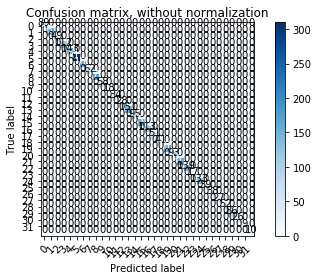

In [36]:
print(__doc__)
import sklearn
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

np.set_printoptions(threshold=np.nan)


class_names = range(32)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y, y_pred)
np.set_printoptions(precision=1)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')


plt.show()


In [ ]:
row = df_categories.iloc[1]
learn.predict(row)

In [ ]:
row = df_categories.iloc[52]
learn.predict(row)

In [ ]:
row.cancertype